<center><h1>Transformer</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

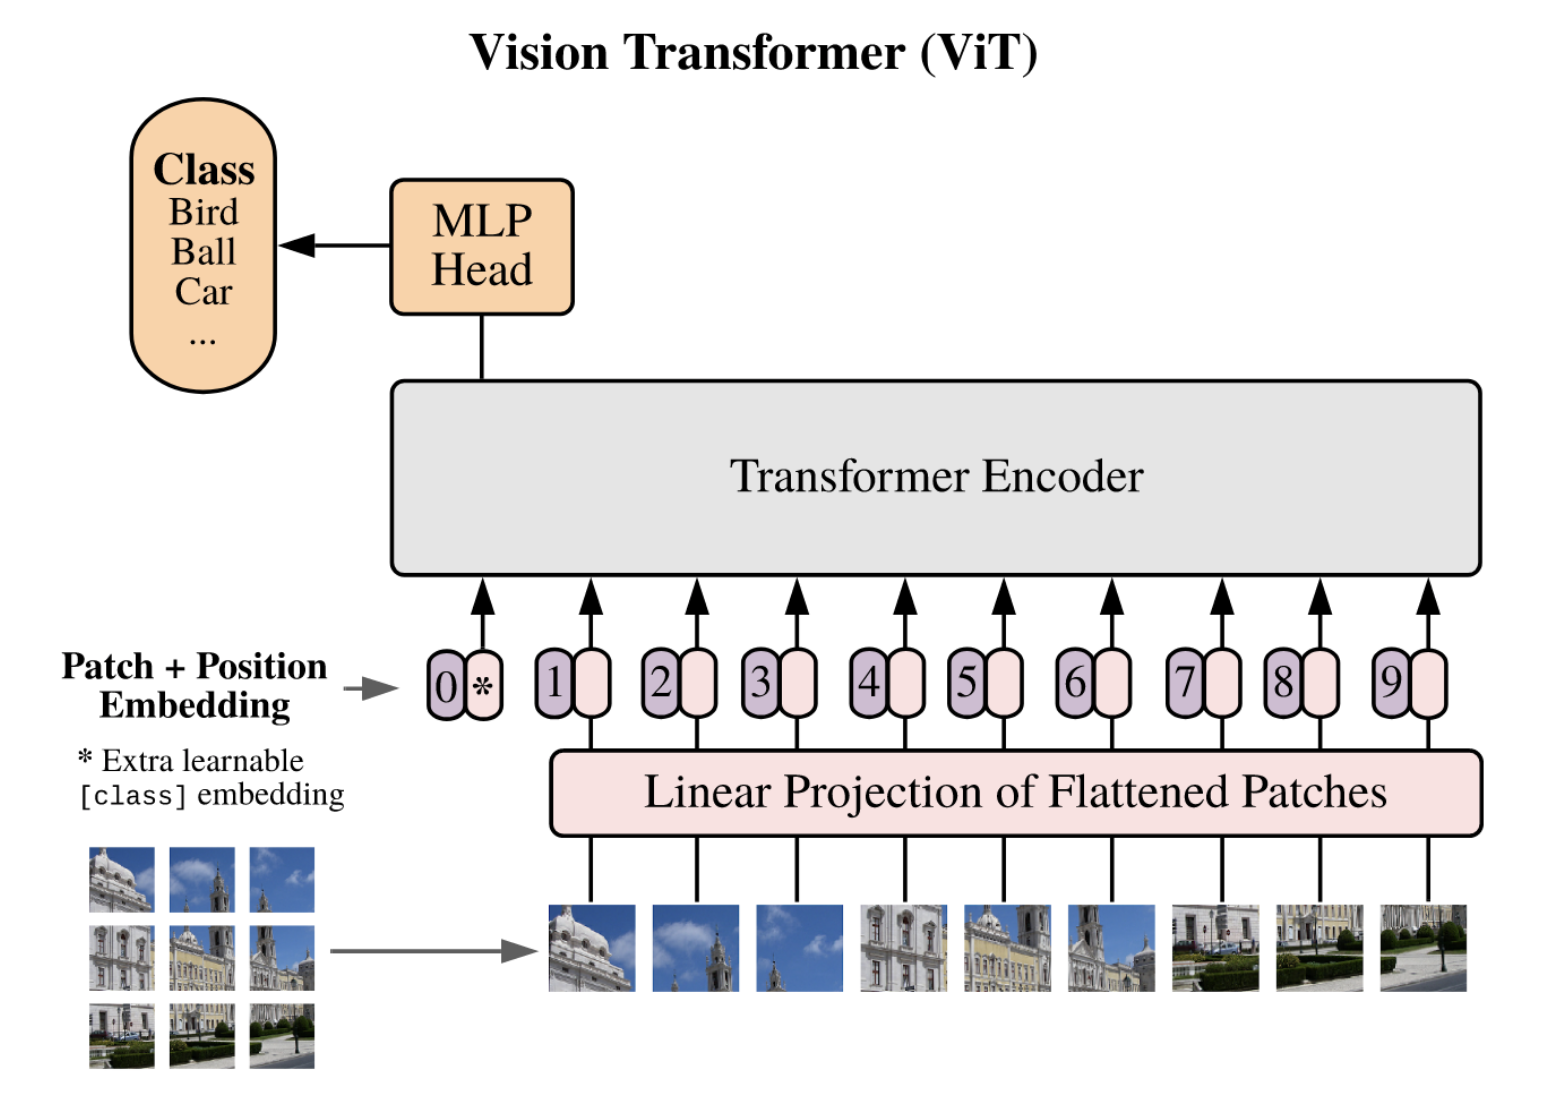

First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a 2d convolution (called "Linear Projection" on the image above) to process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    # TODO: do the linear projection
    x = None

    B, C, H, W = x.shape

    # Reshape appropriately
    x = None

    # Shape is now B, N, D
    # With B the batch size
    # With N the number of tokens (N = H * W)
    # With C the embedding dimension

    return x


PatchEmbed()(torch.randn(3, 1, 28, 28)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/patch.py
%pycat patch.py

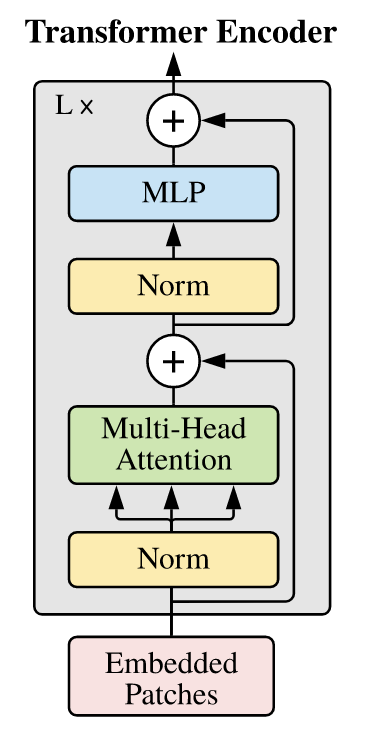

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    # TODO

  def forward(self, x):
    # TODO
    return x


MLP(5, 20)(torch.randn(3, 16, 5)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mlp.py
%pycat mlp.py

Now we are going to build the famous **Self-Attention**. At first, we are going to only consider the simple case of one head.

First create the Q / K / V matrices:

$$\begin{array}{c}
Q=X W_{q} \\
K=X W_{k} \\
V=X W_{v}
\end{array}$$

Then, compute the attention:

$$A=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d}}\right)$$

Then multiply it with the Value:

$$Z=AV$$

And don't forget a final linear projection at the end! Good luck!

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # TODO

  def forward(self, x):
    B, N, C = x.shape
  
    # TODO: compute the Q, K, V
    q = None
    k = None
    v = None

    # TODO: compute the attention matrix using Q and K
    attention = None

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = None

    return x


SelfAttention(6)(torch.randn(2, 4, 6)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/sa.py
%pycat sa.py

Now, we need to assemble the **Self-Attention** and **MLP** into a Transformer **Block**. Look up the previous image to understand how they are arranged.
Don't forget the *Norm*, which are **LayerNorm**.

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, mlp_ratio=4):
    super().__init__()
    
    # TODO

  def forward(self, x):
    # TODO
    return x

Block(6)(torch.randn(2, 4, 6)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/block.py
%pycat block.py

Now, I'm giving you the whole module that combines multiple Blocks together.

Read attentively the forward function and try to understand how the patch embedding, the positional embedding, and the class token are used.

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)
    
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x + self.pos_embed

    class_token = self.class_token.expand(x.shape[0], -1, -1)

    x = torch.cat((class_token, x), dim=1)

    x = self.blocks(x)

    x = self.norm(x)
    return self.head(x[:, 0])  # Only give the class token to the classifier


ViT(6, 3, 7)(torch.randn(16, 1, 28, 28)).shape

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")
  

Transformers are definitely not made for MNIST, and using a simple MLP or CNN would have done a better job quicker. But that's normal. Transformers really shine when given a tons of data. 

The principal is that you know understand better how transformers work, and what is this "attention" that everybody talks about.

If you want to go further, here what you can do:

- Build a **Multi-Heads** Self-Attention (solution given below). The total embedding size will be shared equally among all heads.
- Build a [**CaiT** model](https://arxiv.org/abs/2103.17239) where the class token is only given at the lower blocks, and those lower blocks have a linear complexity w.r.t the number of patch tokens (!!).

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape
  
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO here

    return x


MultiHeadsSelfAttention(6, 2)(x).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mhsa.py
%pycat mha.py